So this colab aims to create a EfficientNetB4 model for 10 class food dataset and compare with B0

The data i get is Daniel Bourke's food data which is divided in to 3 datasets 1 percent, 10 percent and all.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-31 10:56:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-31 10:56:34 (73.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#importing dependencies
import tensorflow as tf
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Getting Data ready

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-08-31 10:56:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   275MB/s    in 0.6s    

2022-08-31 10:56:40 (275 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data("10_food_classes_10_percent.zip")

In [6]:
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percen

In [7]:
# 75 images for training 250 images for testing

train_dir_10 = "10_food_classes_10_percent/train/"
test_dir_10 = "10_food_classes_10_percent/test/"

In [8]:
IMG_SIZE = (224, 224)
input_shape = (224, 224, 3)
train_data_10 = tf.keras.utils.image_dataset_from_directory(train_dir_10,
                                                            label_mode="categorical",
                                                            image_size=IMG_SIZE)

test_data = tf. keras.utils.image_dataset_from_directory(test_dir_10,
                                                         label_mode="categorical",
                                                         image_size=IMG_SIZE) # test_data will be always same so i am just attending it once 

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# Building models

##### We got data ready now its time to build model i am going to build 4 different models
- model_1 is going to be our base model every tuning will be on this one.
- model_2 is going to be only fitted by augmented data.
- model_3 is going to be augmented data + tuning some layers on model_1 (which is not trainable on model_1)
- model_4 is going to be using all data + model_3 tunings

In [10]:
model = tf.keras.applications.EfficientNetB4(include_top=False)
model.trainable = False # freezing all the layers in model so that we can use them directly

inputs = tf.keras.layers.Input(shape=input_shape) # this is our input layer
x = model(inputs) # inputs passed to the model

# its time pool before outputting

x = tf.keras.layers.GlobalAveragePooling2D()(x) # tf.reduce_mean(inputs, axis=[1, 2])

outputs = tf.keras.layers.Dense(10, activation="softmax")(x) # after pooled get outputs to dense layer

71696384/71686520 [==============================] - 2s 0us/step


In [11]:
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [12]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                17930     
                                                                 
Total params: 17,691,753
Trainable params: 17,930
Non-trainable params: 17,673,823
_________________________________________________________________


Before the fit i should create a checkpoint callback in order to call it while fitting

In [64]:
cp_path = "efficient_net_fit_weights/checkpoint"
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,
                                           save_weights_only=True,
                                           save_freq="epoch",
                                           verbose=1)

In [14]:
history_1 = model_1.fit(train_data_10,
                        validation_data=test_data,
                        steps_per_epoch=len(train_data_10),
                        validation_steps=int(0.25*(len(test_data))),
                        epochs=5) # just using 25% of test_data

Epoch 1/5
24/24 [==============================] - 34s 461ms/step - loss: 1.7847 - accuracy: 0.4933 - val_loss: 1.1426 - val_accuracy: 0.7418
Epoch 2/5
24/24 [==============================] - 8s 311ms/step - loss: 1.0182 - accuracy: 0.7480 - val_loss: 0.7952 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 8s 312ms/step - loss: 0.7618 - accuracy: 0.8187 - val_loss: 0.6736 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 8s 314ms/step - loss: 0.6300 - accuracy: 0.8413 - val_loss: 0.6242 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 8s 313ms/step - loss: 0.5529 - accuracy: 0.8587 - val_loss: 0.5838 - val_accuracy: 0.8339


Even though we used 10% of data + didn't make any differences tuning or etc. still we got 80 percent on test data.

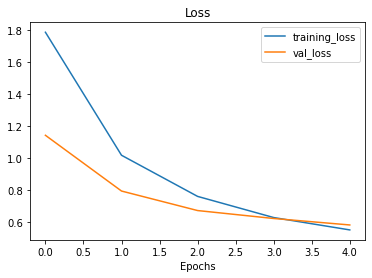

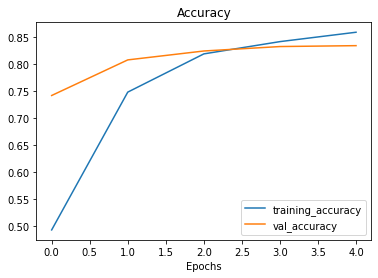

In [15]:
plot_loss_curves(history_1)

Also graphs look cool so its time to play with data

 # Building Data Augmentation Layer

In [66]:
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomHeight(0.3),
    tf.keras.layers.RandomWidth(0.3),
    tf.keras.layers.RandomRotation(0.3),
    #tf.keras.layers.Rescaling(scale=1/255.) EfficientNetB4 also uses rescaling inside of it so we dont need to use this
])

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as imp
import os
import random

In [60]:
from tensorflow.python import training
# lets see how augmented image looks like

def show_augmented_image():
  target_classes = random.choice(train_data_10.class_names)
  target_dir = train_dir_10 + target_classes
  random_image = random.choice(os.listdir(target_dir))
  random_path = target_dir + "/" + random_image
  img = imp.imread(random_path)
  plt.imshow(img)
  plt.axis(False)
  augmented_image = augmentation_layer(img, training=True)
  plt.figure()
  plt.axis(False)
  plt.imshow(augmented_image/255.)

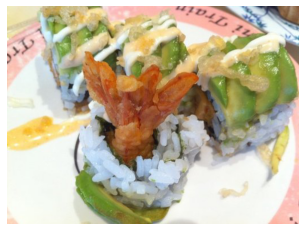

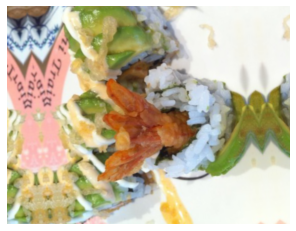

In [62]:
show_augmented_image()

### Building model with augmentated data

In [67]:
model_0 = tf.keras.applications.EfficientNetB4(include_top=False)
model_0.trainable = False
inputs = tf.keras.layers.Input(shape=input_shape)
x = augmentation_layer(inputs)
x = model_0(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data_10,
                        epochs=5,
                        steps_per_epoch=len(train_data_10),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[cp_cb])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9925 - accuracy: 0.3213
Epoch 1: saving model to efficient_net_fit_weights/checkpoint
24/24 [==============================] - 31s 814ms/step - loss: 1.9925 - accuracy: 0.3213 - val_loss: 1.4381 - val_accuracy: 0.6727
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4374 - accuracy: 0.6107
Epoch 2: saving model to efficient_net_fit_weights/checkpoint
24/24 [==============================] - 21s 865ms/step - loss: 1.4374 - accuracy: 0.6107 - val_loss: 1.0516 - val_accuracy: 0.7467
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.2046 - accuracy: 0.6627
Epoch 3: saving model to efficient_net_fit_weights/checkpoint
24/24 [==============================] - 16s 649ms/step - loss: 1.2046 - accuracy: 0.6627 - val_loss: 0.8503 - val_accuracy: 0.7928
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 1.0679 - accuracy: 0.6933
Epoch 4: saving model to efficient_net_fit_wei

### I faced with some problems about vertical flipping so i think from now on i am going to change that flip to horizontal
-- Extra note: after changing flipping to horizontal after fitting val accuracy didn't change.

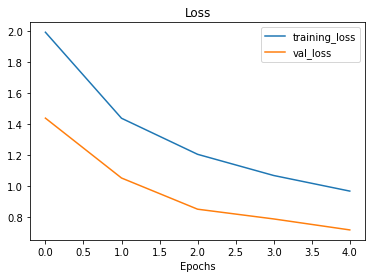

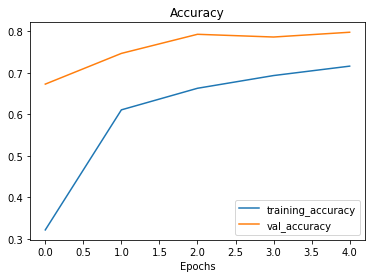

In [68]:
plot_loss_curves(history_2)

### Creating model_3 hardest part begins!!!!
in this model i am going to divide some parts of pretrained imagenet layers in order to train myself.
i hope this is going to work
the other parameters will be same. model_2 will be baseline model after here. In order to use model_2 frequently i am going to use checkpoints to call it.

In [69]:
for layer in model_2.layers:
  print(layer.name, layer.trainable)

input_6 True
sequential_3 True
efficientnetb4 False
global_average_pooling2d_2 True
dense_2 True


#### Upthere there are some trainable layers which is not frozen layers that i created also there is a layer of efficientnetb4 which called frozen. lets heat it!!


In [90]:
for layer in model_2.layers[2].layers:
  print(layer.name, layer.trainable)

input_5 False
rescaling_3 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv

In [76]:
print(len(model_2.layers[2].layers))

474


##### There are "474" layers up there i am going to nearly select last 10% of layers in order to fine tune them lets round this number down and say 45 layers.

In [ ]:
for layer in model_0.layers[:-45:-1]:
  print(i,  " " , layer.name)

In [82]:
print(len(model_0.layers[:-45]))

429


In [83]:
474 - 45

429

#### So we selected last 45 layers up there lets make them trainable in order to fine tuning

In [91]:
for layer in model_0.layers[:-45:-1]:
  layer.trainable = True

In [ ]:
for i, layer in enumerate(model_0.layers):
  print(i, " ", layer.name, " ", layer.trainable)

In [97]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"]) # here we should drop learning rate in order to prevent huge overfitting i am going to talk about it in other section


In [103]:
for i, layer in enumerate(model_2.layers[2].layers):
   print(i, " ", layer.name, " ", layer.trainable)

0   input_5   False
1   rescaling_3   False
2   normalization_2   False
3   stem_conv_pad   False
4   stem_conv   False
5   stem_bn   False
6   stem_activation   False
7   block1a_dwconv   False
8   block1a_bn   False
9   block1a_activation   False
10   block1a_se_squeeze   False
11   block1a_se_reshape   False
12   block1a_se_reduce   False
13   block1a_se_expand   False
14   block1a_se_excite   False
15   block1a_project_conv   False
16   block1a_project_bn   False
17   block1b_dwconv   False
18   block1b_bn   False
19   block1b_activation   False
20   block1b_se_squeeze   False
21   block1b_se_reshape   False
22   block1b_se_reduce   False
23   block1b_se_expand   False
24   block1b_se_excite   False
25   block1b_project_conv   False
26   block1b_project_bn   False
27   block1b_drop   False
28   block1b_add   False
29   block2a_expand_conv   False
30   block2a_expand_bn   False
31   block2a_expand_activation   False
32   block2a_dwconv_pad   False
33   block2a_dwconv   False
34   bl

In [104]:
fine_epochs = 10

history_3 = model_2.fit(train_data_10,
                        epochs=fine_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        initial_epoch=history_2.epoch[-1])

Epoch 5/10
24/24 [==============================] - 33s 827ms/step - loss: 1.3573 - accuracy: 0.6373 - val_loss: 0.7499 - val_accuracy: 0.7977
Epoch 6/10
24/24 [==============================] - 19s 798ms/step - loss: 1.3467 - accuracy: 0.6307 - val_loss: 0.7798 - val_accuracy: 0.7829
Epoch 7/10
24/24 [==============================] - 16s 653ms/step - loss: 1.3157 - accuracy: 0.6520 - val_loss: 0.7886 - val_accuracy: 0.7862
Epoch 8/10
24/24 [==============================] - 18s 743ms/step - loss: 1.3098 - accuracy: 0.6440 - val_loss: 0.8166 - val_accuracy: 0.7796
Epoch 9/10
24/24 [==============================] - 21s 840ms/step - loss: 1.3084 - accuracy: 0.6320 - val_loss: 0.8230 - val_accuracy: 0.7812
Epoch 10/10
24/24 [==============================] - 16s 680ms/step - loss: 1.3131 - accuracy: 0.6480 - val_loss: 0.8549 - val_accuracy: 0.7763


In [105]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 10)                17930     
                                                                 
Total params: 17,691,753
Trainable params: 17,930
Non-trainable params: 17,673,823
__________________________________________

#### So the experiment failed and fine tuning drop the accuracy

In [107]:
model_2.evaluate(test_data)

79/79 [==============================] - 14s 169ms/step - loss: 0.8485 - accuracy: 0.7772


[0.8485168218612671, 0.7771999835968018]

#### Starting again and dropping number of trainable variables

In [108]:
model_2.load_weights(cp_path)

In [109]:
model_2.evaluate(test_data)

79/79 [==============================] - 14s 162ms/step - loss: 0.7215 - accuracy: 0.8020


[0.7215473651885986, 0.8019999861717224]

In [ ]:
for layer in model_2.layers[2].layers:
  print(layer.name, " ", layer.trainable)

In [115]:
for layer in model_0.layers[:-20]:
  print(layer.name, " ", layer.trainable)
  layer.trainable = False

input_5   False
rescaling_3   False
normalization_2   False
stem_conv_pad   False
stem_conv   False
stem_bn   False
stem_activation   False
block1a_dwconv   False
block1a_bn   False
block1a_activation   False
block1a_se_squeeze   False
block1a_se_reshape   False
block1a_se_reduce   False
block1a_se_expand   False
block1a_se_excite   False
block1a_project_conv   False
block1a_project_bn   False
block1b_dwconv   False
block1b_bn   False
block1b_activation   False
block1b_se_squeeze   False
block1b_se_reshape   False
block1b_se_reduce   False
block1b_se_expand   False
block1b_se_excite   False
block1b_project_conv   False
block1b_project_bn   False
block1b_drop   False
block1b_add   False
block2a_expand_conv   False
block2a_expand_bn   False
block2a_expand_activation   False
block2a_dwconv_pad   False
block2a_dwconv   False
block2a_bn   False
block2a_activation   False
block2a_se_squeeze   False
block2a_se_reshape   False
block2a_se_reduce   False
block2a_se_expand   False
block2a_se_exci

In [116]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [118]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i ," " ,layer.name, " ", layer.trainable)

0   input_5   False
1   rescaling_3   False
2   normalization_2   False
3   stem_conv_pad   False
4   stem_conv   False
5   stem_bn   False
6   stem_activation   False
7   block1a_dwconv   False
8   block1a_bn   False
9   block1a_activation   False
10   block1a_se_squeeze   False
11   block1a_se_reshape   False
12   block1a_se_reduce   False
13   block1a_se_expand   False
14   block1a_se_excite   False
15   block1a_project_conv   False
16   block1a_project_bn   False
17   block1b_dwconv   False
18   block1b_bn   False
19   block1b_activation   False
20   block1b_se_squeeze   False
21   block1b_se_reshape   False
22   block1b_se_reduce   False
23   block1b_se_expand   False
24   block1b_se_excite   False
25   block1b_project_conv   False
26   block1b_project_bn   False
27   block1b_drop   False
28   block1b_add   False
29   block2a_expand_conv   False
30   block2a_expand_bn   False
31   block2a_expand_activation   False
32   block2a_dwconv_pad   False
33   block2a_dwconv   False
34   bl

In [120]:
len(model_2.trainable_variables)

2

In [121]:
history_3_second_try = model_2.fit(train_data_10,
                               validation_data=test_data,
                               steps_per_epoch=len(train_data_10),
                               epochs=fine_epochs,
                               validation_steps=int(0.25*len(test_data)),
                               initial_epoch=history_2.epoch[-1])

Epoch 5/10
24/24 [==============================] - 30s 764ms/step - loss: 0.9706 - accuracy: 0.7107 - val_loss: 0.6867 - val_accuracy: 0.7977
Epoch 6/10
24/24 [==============================] - 16s 651ms/step - loss: 0.8892 - accuracy: 0.7413 - val_loss: 0.6633 - val_accuracy: 0.8026
Epoch 7/10
24/24 [==============================] - 19s 773ms/step - loss: 0.7896 - accuracy: 0.7693 - val_loss: 0.6219 - val_accuracy: 0.8174
Epoch 8/10
24/24 [==============================] - 17s 692ms/step - loss: 0.7957 - accuracy: 0.7653 - val_loss: 0.6231 - val_accuracy: 0.7993
Epoch 9/10
24/24 [==============================] - 18s 719ms/step - loss: 0.7301 - accuracy: 0.8000 - val_loss: 0.5832 - val_accuracy: 0.8092
Epoch 10/10
24/24 [==============================] - 18s 757ms/step - loss: 0.7303 - accuracy: 0.7747 - val_loss: 0.5955 - val_accuracy: 0.8059


#### Decreasing trainable variables worked but still don't do well as we expected. So the other trying might be giving all data but we'll see.